<a href="https://colab.research.google.com/github/Zoro114/mne/blob/main/Motor_Imagery_decoding_using_CSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,cross_val_score


import mne
from mne.decoding import CSP
from mne.datasets import eegbci
from mne.io import concatenate_raws,read_raw_edf
from mne.channels import make_standard_montage

In [ ]:
print(__doc__)       

Automatically created module for IPython interactive environment


In [ ]:
tmin,tmax=-1,4
event_id={'hands':2,'feet':3}
subject=1
runs=[6,10,14]


In [ ]:
raw_fname=eegbci.load_data(subject,runs)
raw=concatenate_raws([read_raw_edf(f,preload=True) for f in raw_fname])
eegbci.standardize(raw)
montage=make_standard_montage('standard_1005')
raw.set_montage(montage)

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [ ]:
raw.rename_channels(lambda x :x.strip('.'))

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [ ]:
raw.filter(7,30,fir_design='firwin',skip_by_annotation='edge')

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [ ]:
from mne.annotations import events_from_annotations
events,_=events_from_annotations(raw,event_id=dict(T1=2,T2=3))
events

Used Annotations descriptions: ['T1', 'T2']


array([[  672,     0,     3],
       [ 2000,     0,     2],
       [ 3328,     0,     2],
       [ 4656,     0,     3],
       [ 5984,     0,     2],
       [ 7312,     0,     3],
       [ 8640,     0,     3],
       [ 9968,     0,     2],
       [11296,     0,     2],
       [12624,     0,     3],
       [13952,     0,     3],
       [15280,     0,     2],
       [16608,     0,     2],
       [17936,     0,     3],
       [19264,     0,     3],
       [20672,     0,     2],
       [22000,     0,     3],
       [23328,     0,     3],
       [24656,     0,     2],
       [25984,     0,     3],
       [27312,     0,     2],
       [28640,     0,     2],
       [29968,     0,     3],
       [31296,     0,     3],
       [32624,     0,     2],
       [33952,     0,     2],
       [35280,     0,     3],
       [36608,     0,     3],
       [37936,     0,     2],
       [39264,     0,     3],
       [40672,     0,     3],
       [42000,     0,     2],
       [43328,     0,     3],
       [44

In [ ]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

In [ ]:
epochs=mne.Epochs(raw,events,event_id,tmin,tmax,proj=True,picks=picks,preload=True)

Not setting metadata
45 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


In [ ]:
epochs_train=epochs.copy().crop(tmin=1,tmax=2)
label=epochs.events[:,-1]-2
label

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1])

In [ ]:
scores=[]
epochs_data=epochs.get_data()
epochs_train_data=epochs_train.get_data()
cv=ShuffleSplit(10,test_size=0.2,random_state=3)
cv_split=cv.split(epochs_train_data)

lda=LinearDiscriminantAnalysis()
csp=CSP(n_components=4,reg=None,log=True,norm_trace=False)
clf=Pipeline([('CSP',csp),('LDA',lda)])
scores=cross_val_score(clf,epochs_train_data,label,cv=cv,n_jobs=1)


Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-05 (2.2e-16 eps * 64 dim * 7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-05 (2.2e-16 eps * 64 dim * 6.4e+09  max singular value)
   

In [ ]:
class_balance = np.mean(label == label[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Classification accuracy: 0.955556 / Chance level: 0.533333


Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


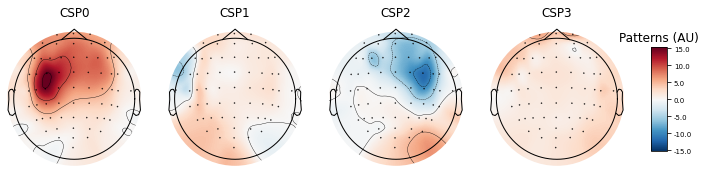

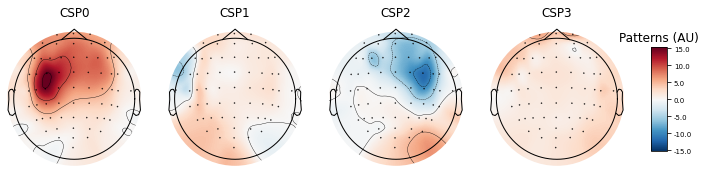

In [ ]:
csp.fit_transform(epochs_data,label)
csp.plot_patterns(epochs.info,ch_type='eeg',units='Patterns (AU)',size=1.5)

Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-05 (2.2e-16 eps * 64 dim * 7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 64 dim * 8.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-05 (2.2e-16 eps * 64 dim * 6.4e+09  max singular value)
   

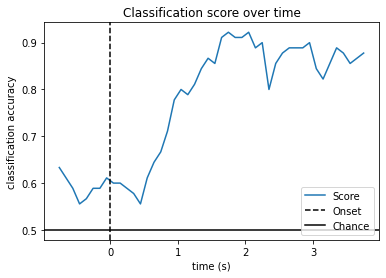

In [ ]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   
w_step = int(sfreq * 0.1)
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:                                                  
    y_train, y_test = label[train_idx], label[test_idx]

    X_train = csp.fit_transform(epochs_train_data[train_idx], y_train)
    X_test = csp.transform(epochs_train_data[test_idx])

    lda.fit(X_train, y_train)

    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()